# Machine Learning & Deep Learning Final Project

**Joana Rio Maior - 176189**

**Maïwenn Mignon - 176196**


In this notebook, we implement a machine learning project focused on the task of predicting whether or not a person is smoking based on images.

We begin by preparing and analyzing the dataset, then explore a range of models, from simpler approaches like logistic regression, to SVMs, and eventually more complex deep learning architectures like CNN. To optimize performance, we apply hyperparameter tuning techniques such as random search, and we also experiment with an hybrid approaches that resulted on our best performing model.

## Collab Set up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip /content/drive/MyDrive/Smoking_data.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/Smoking_data/notsmoking/notsmoking_503.jpg  
  inflating: /content/data/__MACOSX/Smoking_data/notsmoking/._notsmoking_503.jpg  
  inflating: /content/data/Smoking_data/notsmoking/notsmoking_1098.jpg  
  inflating: /content/data/__MACOSX/Smoking_data/notsmoking/._notsmoking_1098.jpg  
  inflating: /content/data/Smoking_data/notsmoking/notsmoking_517.jpg  
  inflating: /content/data/__MACOSX/Smoking_data/notsmoking/._notsmoking_517.jpg  
  inflating: /content/data/Smoking_data/notsmoking/notsmoking_271.jpg  
  inflating: /content/data/__MACOSX/Smoking_data/notsmoking/._notsmoking_271.jpg  
  inflating: /content/data/Smoking_data/notsmoking/notsmoking_1661.jpg  
  inflating: /content/data/__MACOSX/Smoking_data/notsmoking/._notsmoking_1661.jpg  
  inflating: /content/data/Smoking_data/notsmoking/notsmoking_1107.jpg  
  inflating: /content/data/__MACOSX/Smoking_data/notsmoking/._notsmoking_1107.jpg  
  inflating: 

## Data Access

### Imports

In [3]:
import os
import shutil
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tqdm import tqdm
import cv2
from PIL import Image, ImageEnhance
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import class_weight
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 12.2 MB/s eta 0:00:00


### Prepare data set for EDA
In this section, we set the path to our dataset stored in Google Drive.
We then create a DataFrame containing all image file paths and their corresponding labels, which are mapped to numeric values for modeling purposes.
Next, we perform a stratified 70/15/15 split to divide the data into training, validation, and test sets while preserving class balance across all subsets.
Finally, we reorganize the images into a structured folder layout, with separate subfolders for each split and each class that will enable to use genarators fo


In [4]:
base_dir = r"/content/data/Smoking_data"

labels_map = {'smoking': 1, 'notsmoking': 0}
image_extensions = ('.jpg', '.jpeg', '.png')

data = []
for label_folder, label_value in labels_map.items():
    folder_path = os.path.join(base_dir, label_folder)
    for fname in sorted(os.listdir(folder_path)):
        if fname.lower().endswith(image_extensions):
            data.append({
                'filepath': os.path.join(folder_path, fname),
                'label': label_folder,
                'label_encoded': label_value
            })

df = pd.DataFrame(data)

In [5]:
train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label_encoded'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1765, stratify=train_val_df['label_encoded'], random_state=42)

split_base_dir = "/content/data/Smoking_data_split"
splits = {
    "train": train_df,
    "validation": val_df,
    "test": test_df
}

for split_name, split_df in splits.items():
    for _, row in split_df.iterrows():
        label = row['label']
        src_path = row['filepath']
        dest_dir = os.path.join(split_base_dir, split_name, label)
        os.makedirs(dest_dir, exist_ok=True)
        dest_path = os.path.join(dest_dir, os.path.basename(src_path))
        shutil.copy2(src_path, dest_path)

# EDA and Data Preprocessing

### Class Distribution


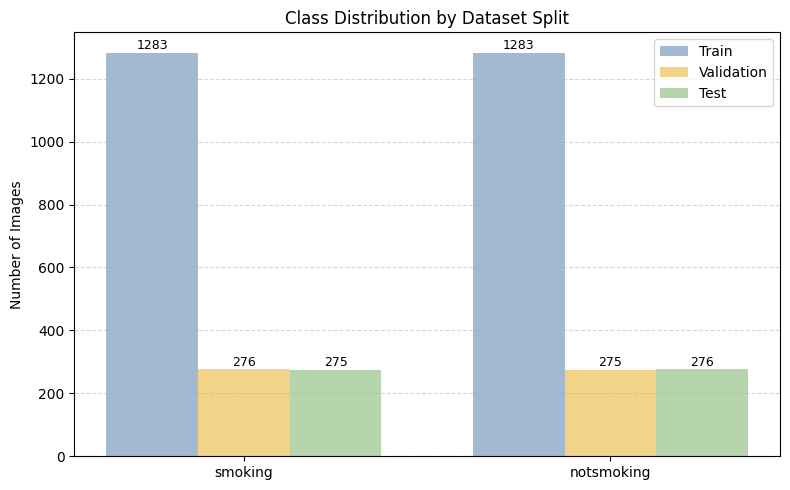

In [6]:

train_counts = train_df['label'].value_counts().reindex(labels_map.keys(), fill_value=0)
val_counts   = val_df['label'].value_counts().reindex(labels_map.keys(), fill_value=0)
test_counts  = test_df['label'].value_counts().reindex(labels_map.keys(), fill_value=0)


labels = list(labels_map.keys())
x = range(len(labels))
bar_width = 0.25

plt.figure(figsize=(8, 5))
train_bars = plt.bar([p - bar_width for p in x], train_counts, width=bar_width, label='Train', color='#A2B9D1')
val_bars   = plt.bar(x, val_counts, width=bar_width, label='Validation', color='#F2D388')
test_bars  = plt.bar([p + bar_width for p in x], test_counts, width=bar_width, label='Test', color='#B7D5AC')


for bar in train_bars + val_bars + test_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2, str(int(height)),
             ha='center', va='bottom', fontsize=9)


plt.xticks(x, labels)
plt.ylabel("Number of Images")
plt.title("Class Distribution by Dataset Split")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


### Sample training images by class

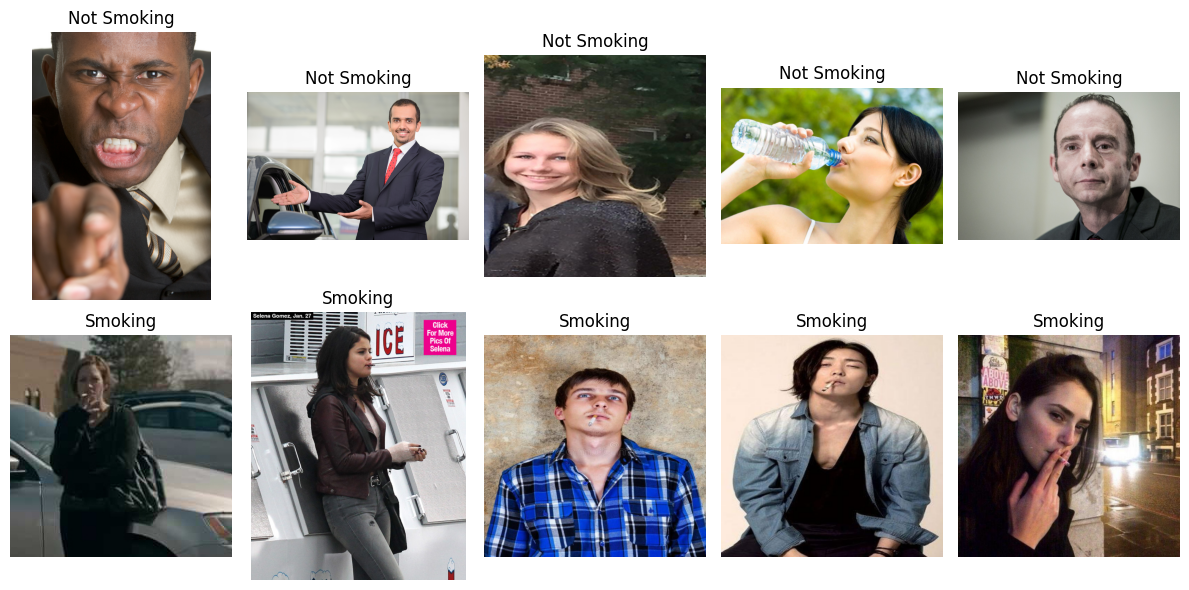

In [7]:
label_map = {0: 'Not Smoking', 1: 'Smoking'}

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()
ax_idx = 0

for label in [0, 1]:
    subset = train_df[train_df['label_encoded'] == label].sample(n=5, random_state=2)
    for _, row in subset.iterrows():
        img = Image.open(row['filepath']).convert('RGB')
        axes[ax_idx].imshow(img)
        axes[ax_idx].set_title(label_map[label])
        axes[ax_idx].axis('off')
        ax_idx += 1

plt.tight_layout()
plt.show()

### Image Dimension Analysis
We checked the sizes of the images in the dataset and found that they vary a lot.
To make the dataset more consistent, we filtered the training data kepping only the images that are between 150×150 and 2000×1600 pixels. Removing about 5% of the dataset (we kept 2429 out of 2566 images). This helps ensure all images are a reasonable size for the model.

In [8]:
widths, heights = [], []

sample_paths = train_df['filepath'].sample(100, random_state=42)

for path in sample_paths:
    try:
        with Image.open(path) as img:
            widths.append(img.width)
            heights.append(img.height)
    except Exception as e:
        print(f"Error reading {path}: {e}")

print("Average width:", np.mean(widths), "Average height:", np.mean(heights))
print("Min width:", np.min(widths), "Max width:", np.max(widths))
print("Min height:", np.min(heights), "Max height:", np.max(heights))

widths = df['filepath'].apply(lambda x: Image.open(x).width)
heights = df['filepath'].apply(lambda x: Image.open(x).height)

print("Width percentiles:", np.percentile(widths, [90, 95, 99]))
print("Height percentiles:", np.percentile(heights, [90, 95, 99]))



Average width: 763.5 Average height: 689.96
Min width: 134 Max width: 5472
Min height: 178 Max height: 5173
Width percentiles: [1280.   1908.6  3877.28]
Height percentiles: [1050.   1500.   3530.99]


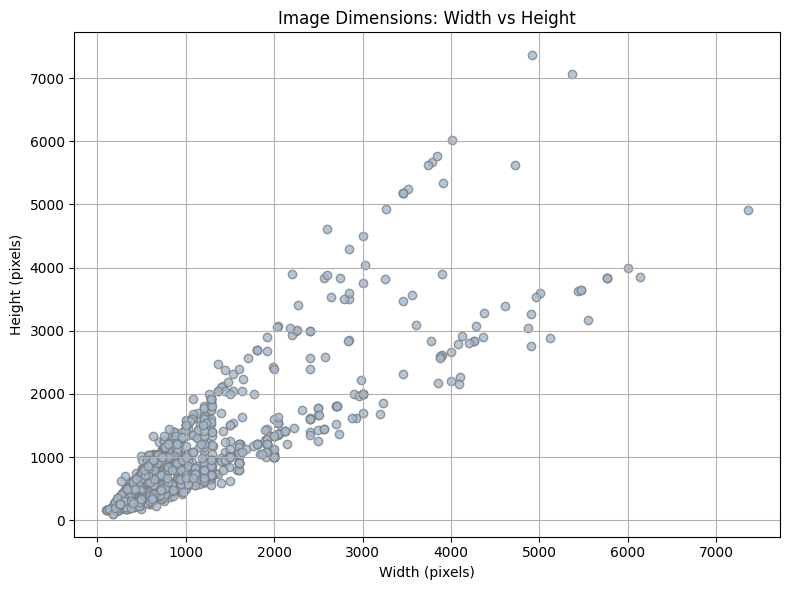

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(widths, heights, color="#A2B9D1", edgecolor='gray', alpha=0.8)
plt.title("Image Dimensions: Width vs Height")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
MIN_W = 150
MIN_H = 150
MAX_W = 2000
MAX_H = 1600

valid_size = train_df['filepath'].apply(lambda path: (
    MIN_W <= (img := Image.open(path)).width <= MAX_W and
    MIN_H <= img.height <= MAX_H
) if path else False)

total = len(train_df)
valid = valid_size.sum()
print(f"Total images       : {total}")
print(f"Images within size : {valid}")
print(f"Images to be removed: {total - valid} ({(1 - valid / total) * 100:.2f}%)")

train_df= train_df[valid_size].reset_index(drop=True)

Total images       : 2566
Images within size : 2429
Images to be removed: 137 (5.34%)


### Brightness and Contrast analysis

In [11]:
brightness_vals = []
contrast_vals = []

sample_df = train_df.sample(500, random_state=42)

for path in sample_df['filepath']:
    try:
        img = Image.open(path).convert('L')
        arr = np.array(img, dtype=np.float32)
        brightness_vals.append(arr.mean())
        contrast_vals.append(arr.std())
    except Exception as e:
        print(f"Error processing {path}: {e}")


brightness_vals = np.array(brightness_vals)
contrast_vals = np.array(contrast_vals)

print(f"Brightness: mean={brightness_vals.mean():.2f}, range=({brightness_vals.min():.1f}–{brightness_vals.max():.1f})")
print(f"Contrast: mean std={contrast_vals.mean():.2f}, range=({contrast_vals.min():.1f}–{contrast_vals.max():.1f})")


Brightness: mean=114.53, range=(14.7–234.2)
Contrast: mean std=61.16, range=(18.3–109.8)


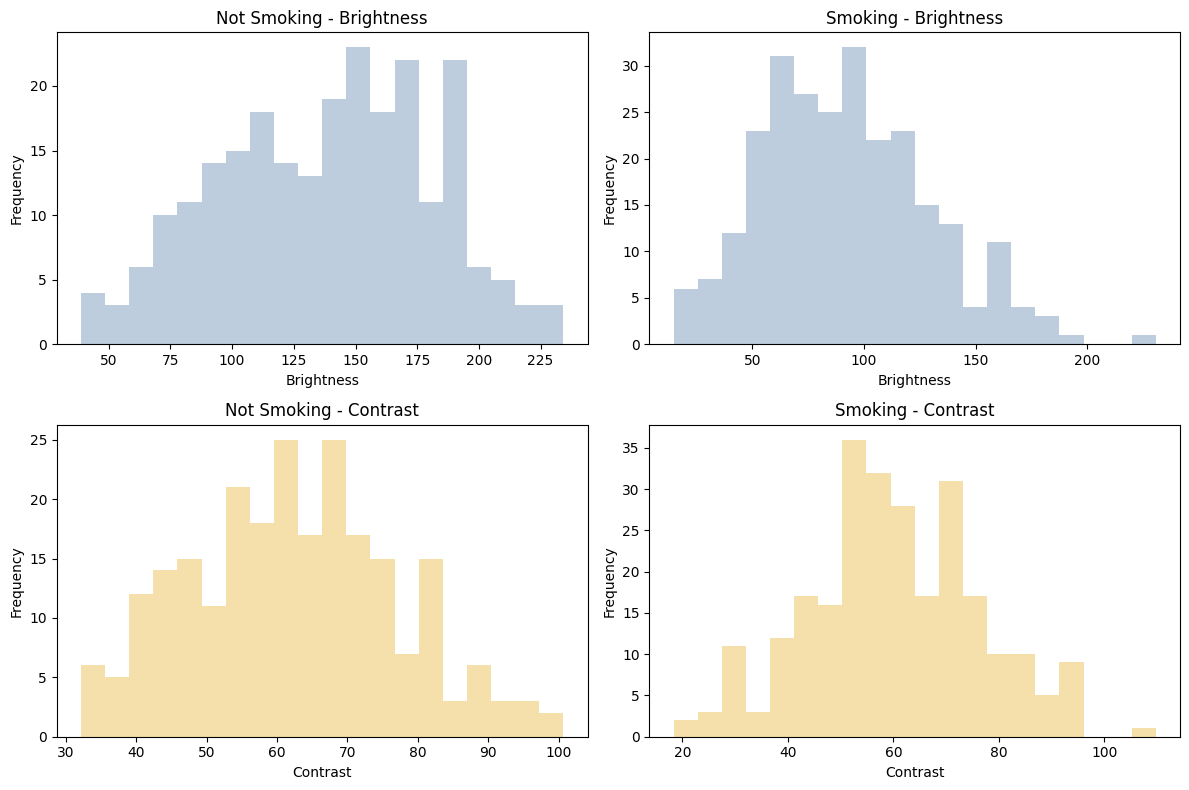

In [12]:
brightness_by_class = {0: [], 1: []}
contrast_by_class = {0: [], 1: []}

for _, row in sample_df.iterrows():
    path = row['filepath']
    label = row['label_encoded']  # 0 or 1

    try:
        img = Image.open(path).convert('L')
        arr = np.array(img, dtype=np.float32)

        brightness_by_class[label].append(arr.mean())
        contrast_by_class[label].append(arr.std())

    except Exception as e:
        print(f"Error processing {path}: {e}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=False)

label_map = {0: 'Not Smoking', 1: 'Smoking'}

for idx, label in enumerate([0, 1]):
    axes[0, idx].hist(brightness_by_class[label], bins=20, color='#A2B9D1', alpha=0.7)
    axes[0, idx].set_title(f'{label_map[label]} - Brightness')
    axes[0, idx].set_xlabel('Brightness')
    axes[0, idx].set_ylabel('Frequency')

    axes[1, idx].hist(contrast_by_class[label], bins=20, color='#F2D388', alpha=0.7)
    axes[1, idx].set_title(f'{label_map[label]} - Contrast')
    axes[1, idx].set_xlabel('Contrast')
    axes[1, idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Data Augmentation

We started by resizing all original training images to 224×224 pixels and saved them into a new folder (train_aug)

To increase the size of our training set and improve generalization, we applied light data augmentation. For each image in the training set, we generated 5 new images with random combinations of these transformations:

* Zoom (zoom_range=0.03)

* Small horizontal and vertical shifts (width_shift_range and height_shift_range = 0.03)

* Brightness adjustment (brightness_range=[0.95, 1.05])

* No horizontal flip

Although we applied rescale=1./255 during augmentation, this only affected the images temporarily in memory for that reason they will be normalized again later during training.


In [13]:
train_aug_dir = "/content/data/Smoking_data_split/train_aug"

image_size = (224, 224)
num_augmented_images = 5

# Copy all the images from the train to the train augemented folder
for _, row in train_df.iterrows():
    label = row['label']
    src_path = row['filepath']
    dest_dir = os.path.join(train_aug_dir, label)
    os.makedirs(dest_dir, exist_ok=True)
    dest_path = os.path.join(dest_dir, os.path.basename(src_path))
    img = load_img(src_path, target_size=image_size)
    img.save(dest_path)

# Augmentation Strategy
aug_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.03,
    width_shift_range=0.03,
    height_shift_range=0.03,
    brightness_range=[0.95, 1.05],
    horizontal_flip=False
)

# Generate augmented images
for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Augmenting images"):
    label = row['label']
    src_path = row['filepath']

    dest_dir = os.path.join(train_aug_dir, label)
    os.makedirs(dest_dir, exist_ok=True)
    fname = os.path.basename(src_path)
    base_name = os.path.splitext(fname)[0]

    img = load_img(src_path, target_size=image_size)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    original_dest = os.path.join(dest_dir, fname)
    if not os.path.exists(original_dest):
        img.save(original_dest)

    aug_iter = aug_datagen.flow(x, batch_size=1)
    for i in range(num_augmented_images):
        aug_img = next(aug_iter)[0]
        aug_img = array_to_img(aug_img * 255.0, scale=False)
        aug_filename = f"{base_name}_aug{i+1}.jpg"
        aug_img.save(os.path.join(dest_dir, aug_filename))


Augmenting images: 100%|██████████| 2429/2429 [02:28<00:00, 16.31it/s]


In [14]:
aug_data = []
for label in labels_map.keys():
    folder_path = os.path.join(train_aug_dir, label)
    for fname in sorted(os.listdir(folder_path)):
        if fname.lower().endswith(image_extensions):
            aug_data.append({
                'filepath': os.path.join(folder_path, fname),
                'label': label,
                'label_encoded': labels_map[label]
            })

train_aug_df = pd.DataFrame(aug_data)

### Resizing and Normalization for Model Input

We prepared the data using ImageDataGenerator to load and preprocess images for training, validation, and testing. We applied rescale=1./255 to normalize pixel values to the [0, 1] range. All images are resized to 224×224, and the data is loaded with shuffling in training for better generalization, and no shuffling for validation and test.

In [15]:
datagen = ImageDataGenerator(rescale=1./255)

train_aug_df['label_encoded'] = train_aug_df['label_encoded'].astype(str)
val_df['label_encoded'] = val_df['label_encoded'].astype(str)
test_df['label_encoded'] = test_df['label_encoded'].astype(str)

train_generator_aug = datagen.flow_from_dataframe(
    dataframe=train_aug_df,
    x_col='filepath',
    y_col='label_encoded',
    target_size=image_size,
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    seed=42
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label_encoded',
    target_size=image_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label_encoded',
    target_size=image_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 14574 validated image filenames belonging to 2 classes.
Found 551 validated image filenames belonging to 2 classes.
Found 551 validated image filenames belonging to 2 classes.


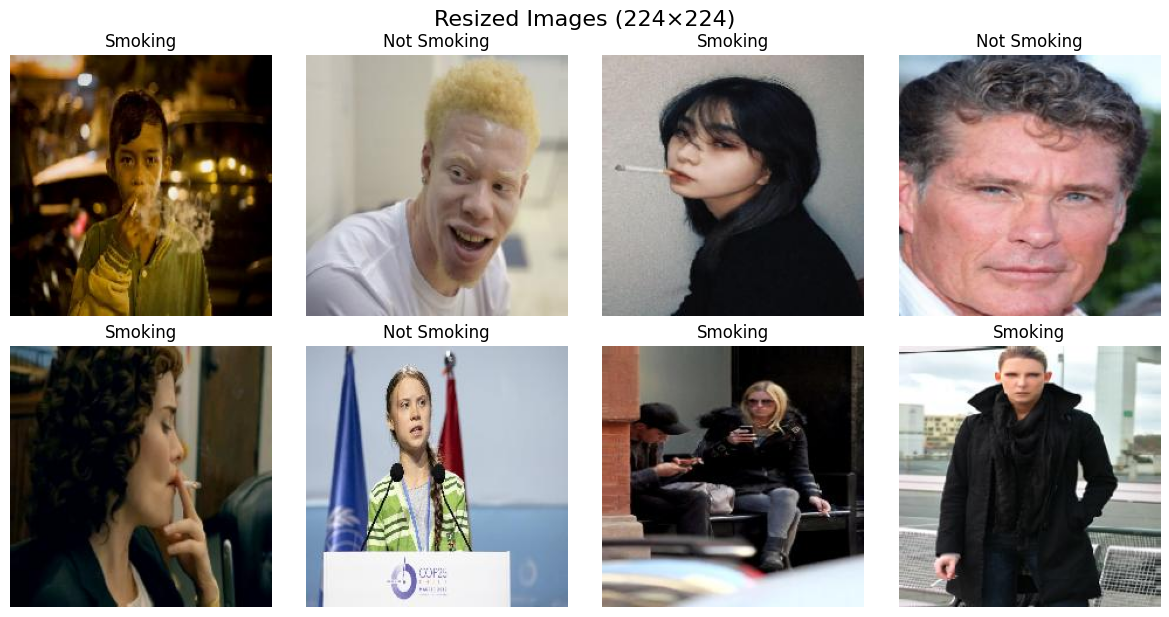

In [16]:
# We replot the images to check that they weren't distorted by resizing
batch_images, batch_labels = next(train_generator_aug)

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(batch_images[i])
    label = "Smoking" if batch_labels[i] == 1 else "Not Smoking"
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Resized Images (224×224)", y=1.02, fontsize=16)
plt.show()


# Models

### Functions to evaluate models
To evaluate our models consistently, we defined two custom functions: one for traditional machine learning models like Logistic Regression and SVM (evaluate_model), and another for deep learning models (evaluate_dl_model).

The functions display:

*   Classification metrics
*   Confusion matrix
*   Most confidently misclassified images
*   Training and validation accuracy/loss curves (just for evaluate_dl_model)


In [17]:
def evaluate_model(model, X_test, y_test, image_paths=None, model_name="Model",
                   target_names=["Non-Smoker", "Smoker"], top_n=5, img_size=(224, 224)):

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Classification metrics
    acc = accuracy_score(y_test, y_pred)
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, target_names=target_names))
    print(f"Accuracy: {acc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # 5 Most confidently misclassified images
    if image_paths is not None:
        errors = np.where(y_pred != y_test)[0]
        if len(errors) == 0:
            print("No misclassified images.")
            return

        confidences = np.abs(y_proba[errors] - 0.5)
        top_errors_idx = errors[np.argsort(-confidences)[:top_n]]

        print(f"\nTop {top_n} most confidently misclassified images:")

        plt.figure(figsize=(3 * top_n, 4))
        for i, idx in enumerate(top_errors_idx):
            img = load_img(image_paths[idx], target_size=img_size)
            plt.subplot(1, top_n, i + 1)
            plt.imshow(img)
            plt.axis("off")
            pred_label = target_names[int(y_pred[idx])]
            true_label = target_names[int(y_test[idx])]
            confidence = y_proba[idx]
            plt.title(f"P: {pred_label}\nT: {true_label}\nConf: {confidence:.2f}")
        plt.tight_layout()
        plt.show()


In [29]:

def evaluate_dl_model(model, history, X_test, y_test, model_name="Model",
                      image_paths=None, top_n=5, img_size=(224, 224),
                      target_names=["Non-Smoker", "Smoker"]):

    # Training curves
    if history is not None:
        plt.figure(figsize=(12, 5))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f'{model_name} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'{model_name} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
    y_test = np.array(y_test).flatten()

    # Classification metrics
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, target_names=target_names))



    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

    # 5 Most confidently misclassified images
    if image_paths is not None:
        errors = np.where(y_pred != y_test)[0]
        if len(errors) == 0:
            print("No misclassified images.")
            return

        top_n = min(top_n, len(errors))
        confidences = np.abs(y_pred_probs[errors].flatten() - 0.5)
        top_errors_idx = errors[np.argsort(-confidences)[:top_n]]

        print(f"\nTop {top_n} most confidently misclassified images:")

        plt.figure(figsize=(3 * top_n, 4))
        for i, idx in enumerate(top_errors_idx):
            img = load_img(image_paths[idx], target_size=img_size)
            plt.subplot(1, top_n, i + 1)
            plt.imshow(img)
            plt.axis("off")
            pred_label = target_names[int(y_pred[idx])]
            true_label = target_names[int(y_test[idx])]
            confidence = float(y_pred_probs[idx])
            plt.title(f"P: {pred_label}\nT: {true_label}\nConf: {confidence:.2f}")
        plt.tight_layout()
        plt.show()


### Prepare data for Ml Models

To prepare the data for traditional machine learning models, we defined a function that:

*   Loads the images in grayscale
*   Resizes them to 64×64 pixels
*   Normalizes pixel values to the [0, 1] range,
*   Flattens the image into a 1D vector
*   We standardized the features (each feature has zero mean and unit variance)

After this we used PCA to reduce the dimensionality of our data. Although 537 components explain 95% of the variance, we chose 150 components instead. This gave us better results in practice, and from the plot we can see the explained variance curve starts to flatten around that point (meaning additional components add little new information).


In [33]:
img_size_ml_models = (64, 64)

def load_and_flatten_images(df, target_size=img_size_ml_models):
    X = []
    y = []
    for _, row in df.iterrows():
        img_path = row['filepath']
        label = row['label_encoded']
        try:
            img = load_img(img_path, target_size=target_size, color_mode='grayscale')
            img_array = img_to_array(img).squeeze()
            img_array = img_array / 255.0
            X.append(img_array.flatten())
            y.append(label)
        except Exception as e:
            print(f"Error loading image: {img_path}, {e}")
    return np.array(X), np.array(y)

X_train_aug, y_train_aug = load_and_flatten_images(train_aug_df)
X_val, y_val = load_and_flatten_images(val_df)
X_test, y_test = load_and_flatten_images(test_df)

scaler = StandardScaler()
X_train_aug_scaled = scaler.fit_transform(X_train_aug)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

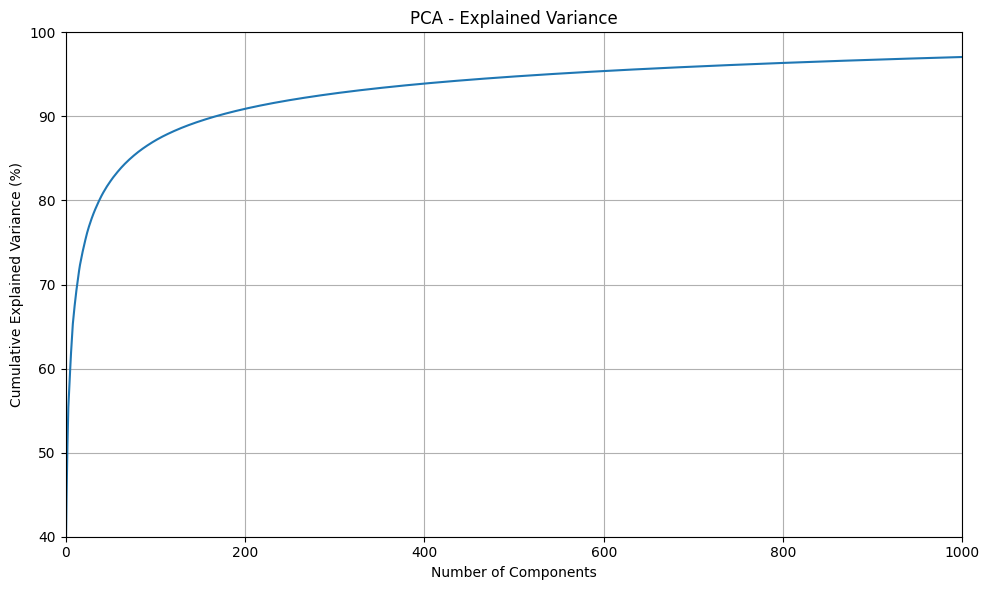

Number of components that explain 95.0% of the variance: 538


In [20]:
pca_test = PCA().fit(X_train_aug_scaled)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_test.explained_variance_ratio_) * 100)
plt.xlim(0, 1000)
plt.ylim(40, 100)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("PCA - Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

# Number of components that explain 95% of variance
n_components_95 = np.argmax(np.cumsum(pca_test.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components that explain {0.95* 100}% of the variance: {n_components_95}")

In [34]:
pca = PCA(n_components=150)
X_train_aug_pca = pca.fit_transform(X_train_aug_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)


##Logic Regression (Baseline model)

Accuracy on the test set: **70%**

*   We set max_iter=1000 to ensure convergence during training



Classification Report for Model:

              precision    recall  f1-score   support

  Non-Smoker       0.71      0.69      0.70       276
      Smoker       0.70      0.71      0.70       275

    accuracy                           0.70       551
   macro avg       0.70      0.70      0.70       551
weighted avg       0.70      0.70      0.70       551

Accuracy: 0.7005


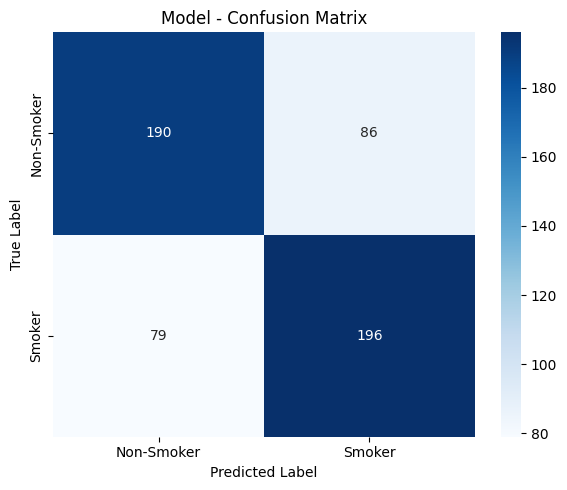


Top 5 most confidently misclassified images:


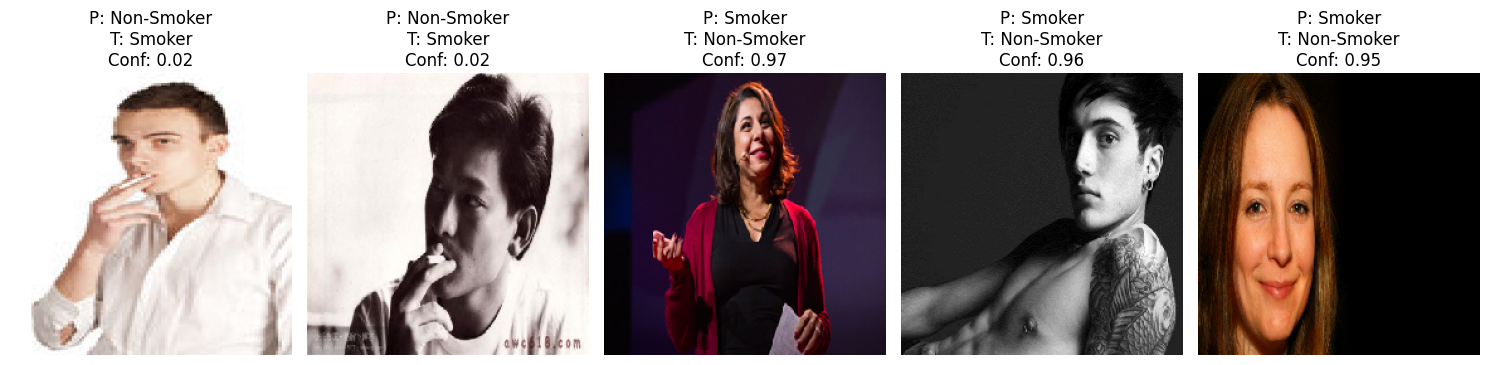

In [35]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_aug_pca, y_train_aug)

evaluate_model(logreg, X_test_pca, y_test, image_paths=test_df['filepath'].tolist())

## SVM (1 Model)

Accuracy on the test set: **77,5%**

We use a RBF kernel and we set:

*   C=1.0 (Controls how much the model tries to avoid misclassifying each training example)

*   gamma='scale' (The model automatically chooses how far the influence of each training point reaches)

*   probability=True (enables probability estimates for evaluation and visualization)


Classification Report for Model:

              precision    recall  f1-score   support

  Non-Smoker       0.79      0.75      0.77       276
      Smoker       0.76      0.80      0.78       275

    accuracy                           0.77       551
   macro avg       0.78      0.78      0.77       551
weighted avg       0.78      0.77      0.77       551

Accuracy: 0.7750


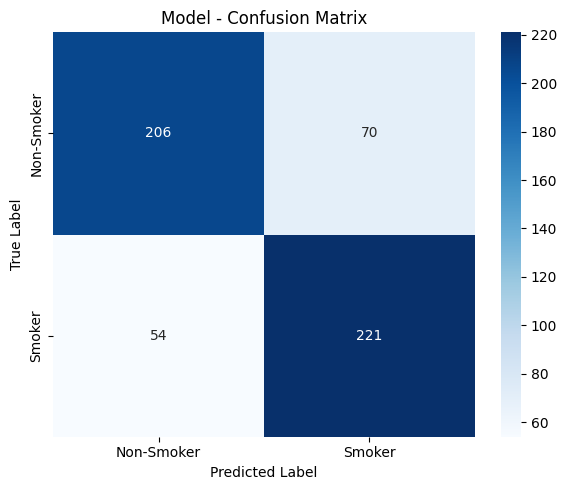


Top 5 most confidently misclassified images:


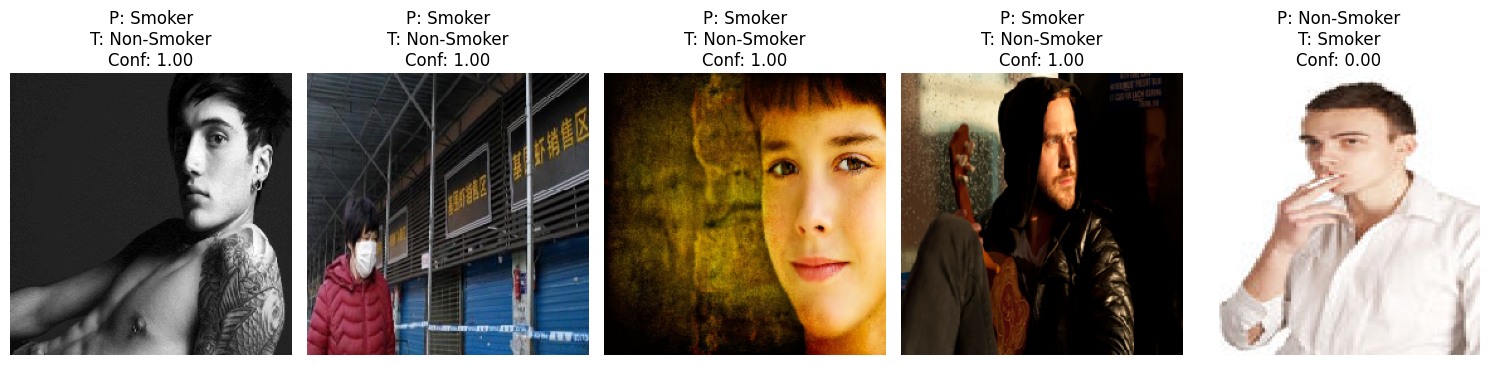

In [23]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm.fit(X_train_aug_pca, y_train_aug)

evaluate_model(svm, X_test_pca, y_test, image_paths=test_df['filepath'].tolist())

## Improved CNN (2 Model)
Accuracy on the test set: **84%**

We started by building a simple CNN architecture and gradually increased its complexity as we observed that the model could handle it without overfitting.
After that we used Keras Tuner’s Random Search (30 trials, 20 epochs due to computational power constraints) and we got these as the best combination of parameters:

*   kernel_size = 5
*   dense_units = 64
*   dropout_rate = 0.20
*   learning_rate = 7.3e-05

Other choices based on our experinces:


*   Increasing Number of Filters 32, 64, 128, 256
*   Batch Normalization after the activation function



In [ ]:
def improved_cnn():
    model = models.Sequential()

    model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (5, 5), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (5, 5), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.20))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=7.3e-05),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

improved_cnn = improved_cnn()

To improve training efficiency and prevent overfitting, we used three standard callbacks:


*   **EarlyStopping** (Stops training if validation loss doesn't improve for 5 consecutive epochs)
*   **ReduceLROnPlateau:** Reduces the learning rate by a factor of 0.5 if the validation loss plateaus for 2 epochs, allowing the model to fine-tune its learning as it converges)
*   **ModelCheckpoint** (Saves the best version of the model based on val accuracy to reuse later)




In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
checkpoint_path = "/content/data/models/improved_cnn_RS.h5"
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
callbacks = [early_stop, reduce_lr, model_checkpoint]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7271 - loss: 0.5608
Epoch 1: val_accuracy improved from -inf to 0.69328, saving model to /content/data/models/improved_cnn_RS.h5


456/456 ━━━━━━━━━━━━━━━━━━━━ 36s 64ms/step - accuracy: 0.7271 - loss: 0.5607 - val_accuracy: 0.6933 - val_loss: 0.5434 - learning_rate: 7.3000e-05
Epoch 2/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8060 - loss: 0.4286
Epoch 2: val_accuracy improved from 0.69328 to 0.72414, saving model to /content/data/models/improved_cnn_RS.h5


456/456 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.8060 - loss: 0.4286 - val_accuracy: 0.7241 - val_loss: 0.5331 - learning_rate: 7.3000e-05
Epoch 3/50
455/456 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8432 - loss: 0.3683
Epoch 3: val_accuracy improved from 0.72414 to 0.77495, saving model to /content/data/models/improved_cnn_RS.h5


456/456 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.8432 - loss: 0.3683 - val_accuracy: 0.7750 - val_loss: 0.4785 - learning_rate: 7.3000e-05
Epoch 4/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8648 - loss: 0.3247
Epoch 4: val_accuracy improved from 0.77495 to 0.82214, saving model to /content/data/models/improved_cnn_RS.h5


456/456 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.8648 - loss: 0.3246 - val_accuracy: 0.8221 - val_loss: 0.4414 - learning_rate: 7.3000e-05
Epoch 5/50
455/456 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9036 - loss: 0.2506
Epoch 5: val_accuracy did not improve from 0.82214
456/456 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.9036 - loss: 0.2506 - val_accuracy: 0.7822 - val_loss: 0.5985 - learning_rate: 7.3000e-05
Epoch 6/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9320 - loss: 0.1923
Epoch 6: val_accuracy did not improve from 0.82214
456/456 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.9320 - loss: 0.1923 - val_accuracy: 0.8185 - val_loss: 0.4402 - learning_rate: 7.3000e-05
Epoch 7/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9611 - loss: 0.1292
Epoch 7: val_accuracy did not improve from 0.82214
456/456 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.9611 - loss: 0.1292 - val_accuracy: 0.8113 - val_loss: 0.4688 - learning_rate: 7.3000e-0

456/456 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.9726 - loss: 0.0934 - val_accuracy: 0.8276 - val_loss: 0.5240 - learning_rate: 7.3000e-05
Epoch 9/50
456/456 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9933 - loss: 0.0441
Epoch 9: val_accuracy improved from 0.82759 to 0.83485, saving model to /content/data/models/improved_cnn_RS.h5


456/456 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.9933 - loss: 0.0440 - val_accuracy: 0.8348 - val_loss: 0.4915 - learning_rate: 3.6500e-05
Epoch 10/50
455/456 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9978 - loss: 0.0268
Epoch 10: val_accuracy did not improve from 0.83485
456/456 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.9978 - loss: 0.0268 - val_accuracy: 0.8258 - val_loss: 0.5546 - learning_rate: 3.6500e-05
Epoch 11/50
455/456 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9993 - loss: 0.0179
Epoch 11: val_accuracy improved from 0.83485 to 0.84936, saving model to /content/data/models/improved_cnn_RS.h5


456/456 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.9993 - loss: 0.0179 - val_accuracy: 0.8494 - val_loss: 0.5105 - learning_rate: 1.8250e-05


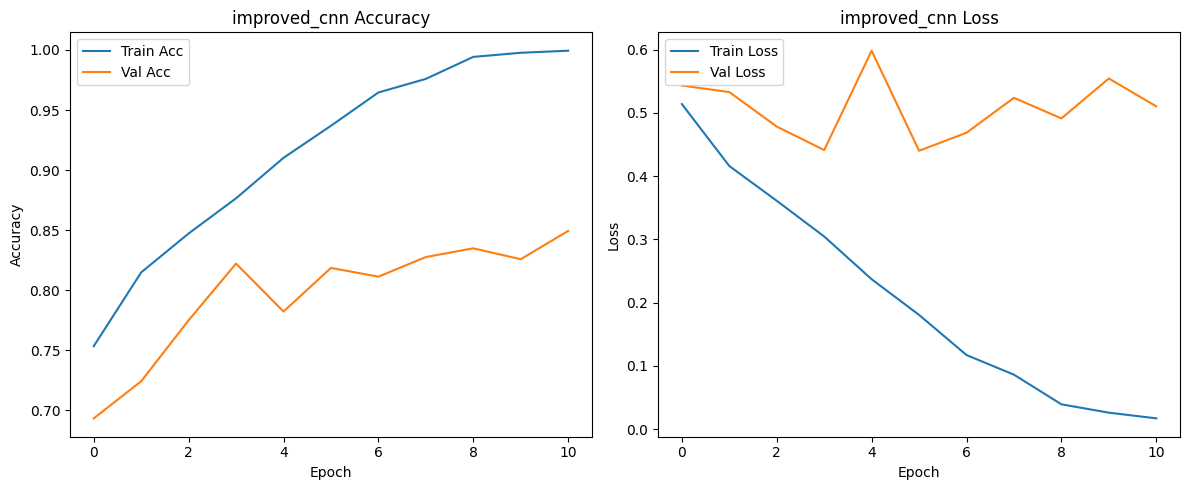

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step

Classification Report for improved_cnn:

              precision    recall  f1-score   support

  Non-Smoker       0.83      0.85      0.84       276
      Smoker       0.84      0.83      0.83       275

    accuracy                           0.84       551
   macro avg       0.84      0.84      0.84       551
weighted avg       0.84      0.84      0.84       551



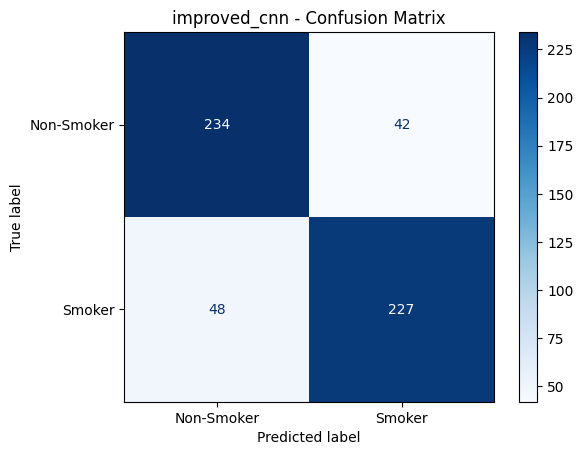


Top 5 most confidently misclassified images:


<ipython-input-29-f8713547631b>:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(y_pred_probs[idx])


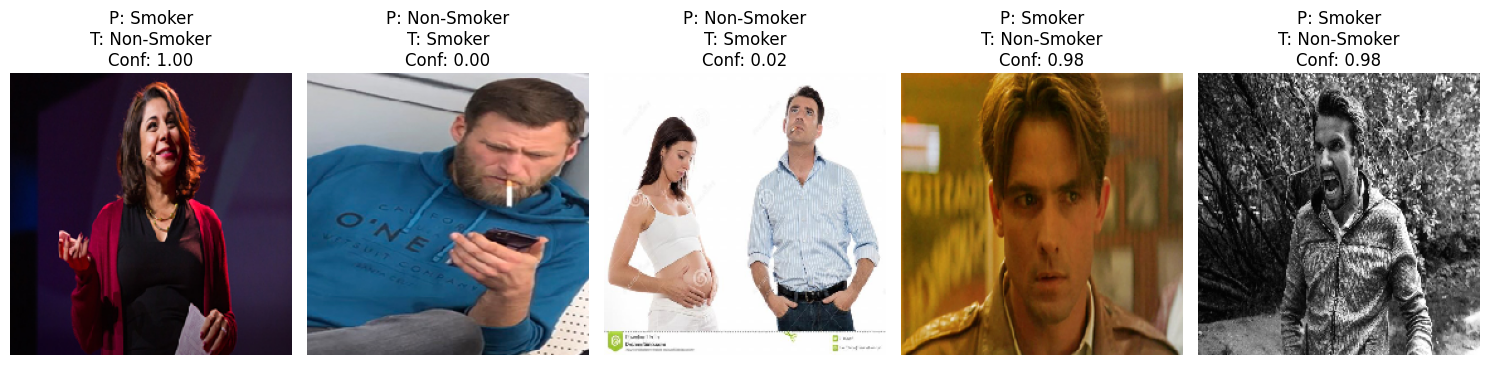

In [30]:
history = improved_cnn.fit(
    train_generator_aug,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks
)
true_labels = test_df['label_encoded'].astype(int).values
evaluate_dl_model(
    model=improved_cnn,
    history=history,
    X_test=test_generator,
    y_test=test_generator.labels,
    model_name="improved_cnn",
    image_paths=test_df['filepath'].tolist(),
    img_size=(224, 224)
)

## SVM with CNN for feature extraction (3 Model)
Accuracy on the test set: **85,5%**

We extracted the output from the Global Average Pooling (GAP) layer of our fine tunned CNN model to use as high-level image features. These features were then standardized and passed to an SVM classifier.

To further optimize performance, we ran a grid search to tune the SVM’s hyperparameters (which matched the configuration of our earlier SVM)

*   C = 1.0
*   gamma ='scale'



In [ ]:
base_cnn = load_model("/content/data/models/improved_cnn_RS.h5", compile=False)
inp = Input(shape=(224, 224, 3))
x = inp
for layer in base_cnn.layers:
    x = layer(x)
    if isinstance(layer, GlobalAveragePooling2D):
        break
feature_extractor = Model(inputs=inp, outputs=x, name="feature_extractor")

def extract_cnn_features(df, model, batch_size=32, target_size=(224, 224)):
    datagen = ImageDataGenerator(rescale=1./255)
    gen = datagen.flow_from_dataframe(
        dataframe=df,
        x_col="filepath",
        y_col=None,
        target_size=target_size,
        class_mode=None,
        batch_size=batch_size,
        shuffle=False
    )
    steps = math.ceil(len(df) / batch_size)
    features = model.predict(gen, steps=steps, verbose=1)
    labels = df['label_encoded'].astype(int).values
    return features, labels

X_train, y_train = extract_cnn_features(train_df, feature_extractor)
X_val, y_val     = extract_cnn_features(val_df, feature_extractor)
X_test, y_test   = extract_cnn_features(test_df, feature_extractor)

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

Found 2429 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step
Found 551 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step
Found 551 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step

Classification Report for Model:

              precision    recall  f1-score   support

  Non-Smoker       0.87      0.83      0.85       276
      Smoker       0.84      0.88      0.86       275

    accuracy                           0.85       551
   macro avg       0.86      0.85      0.85       551
weighted avg       0.86      0.85      0.85       551

Accuracy: 0.8548


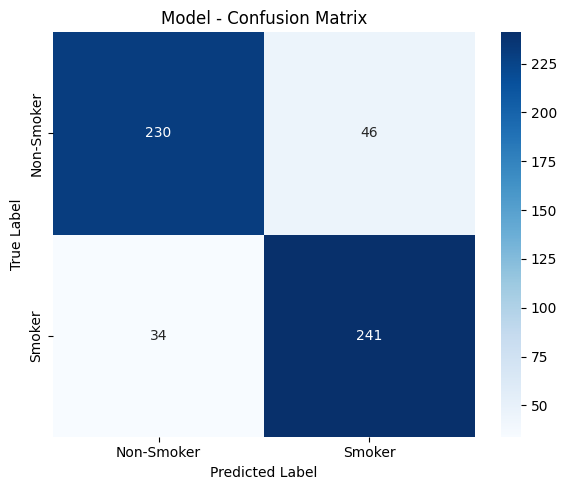


Top 5 most confidently misclassified images:


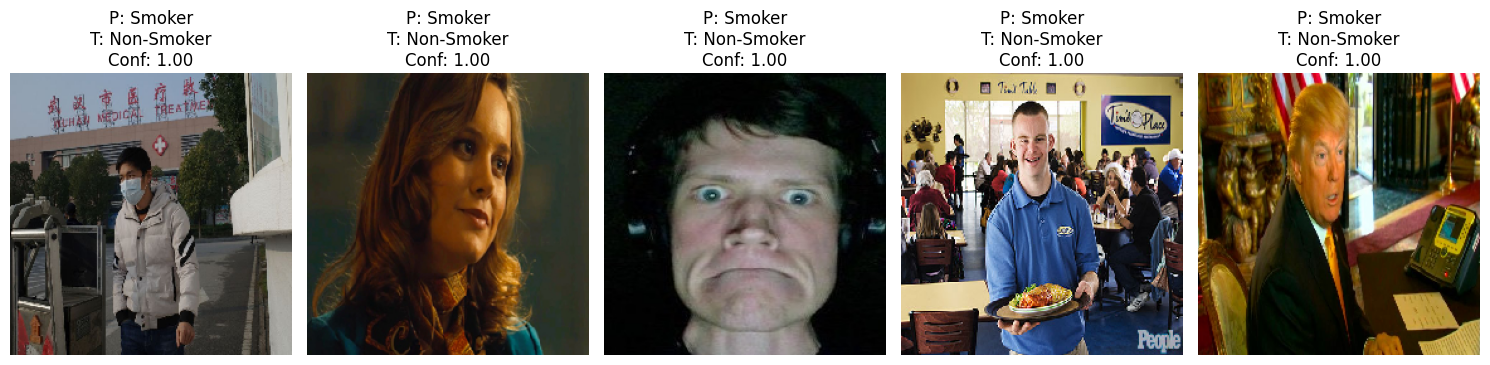

In [31]:
svm = SVC(kernel='rbf', C=0.1, gamma='scale', probability=True)
svm.fit(X_train_s, y_train)

evaluate_model(svm, X_test_s, y_test, image_paths=test_df['filepath'].tolist())


## Grid Search for SVM

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001, 0.0001],
}
grid = GridSearchCV(
    estimator=SVC(probability=True),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train_s, y_train)
print("\nBest Parameters:", grid.best_params_)
print("\nBest F1-Score (CV):", grid.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Parameters: {'C': 0.1, 'gamma': 'scale'}

Best F1-Score (CV): 1.0


## Random Search for CNN Model

In [ ]:
pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
def build_model(hp):
    model = models.Sequential()

    ks = hp.Choice("kernel_size", [3, 5])
    for filters in [32, 64, 128, 256]:
        if not model.layers:
            model.add(layers.Conv2D(filters, (ks, ks), activation="relu",
                                    padding="same", input_shape=(224,224,3)))
        else:
            model.add(layers.Conv2D(filters, (ks, ks), activation="relu", padding="same"))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.GlobalAveragePooling2D())

    du = hp.Choice("dense_units", [64, 128, 256])
    model.add(layers.Dense(du, activation="relu"))

    dr = hp.Float("dropout_rate", 0.2, 0.6, step=0.1)
    model.add(layers.Dropout(dr))

    model.add(layers.Dense(1, activation="sigmoid"))

    lr = hp.Float("learning_rate", 1e-5, 1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=30,
    executions_per_trial=1,
    directory="kt_tuner_dir",
    project_name="cnn_randomsearch"
)

stop_early = EarlyStopping(monitor="val_loss", patience=5)
ckpt     = ModelCheckpoint("/content/data/models/best_RS_model.keras",monitor="val_accuracy",save_best_only=True,save_weights_only=False,verbose=1)


tuner.search(
    train_generator_aug,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[stop_early, ckpt]
)

top5 = tuner.get_best_hyperparameters(num_trials=5)
for i, hp in enumerate(top5, 1):
    print(f"\n=== Trial #{i} ===")
    print(f"kernel_size:    {hp.get('kernel_size')}")
    print(f"dense_units:    {hp.get('dense_units')}")
    print(f"dropout_rate:   {hp.get('dropout_rate'):.2f}")
    print(f"learning_rate:  {hp.get('learning_rate'):.1e}")


Trial 30 Complete [00h 09m 43s]
val_accuracy: 0.7931034564971924

Best val_accuracy So Far: 0.8294010758399963
Total elapsed time: 02h 40m 22s

=== Trial #1 ===
kernel_size:    5
dense_units:    64
dropout_rate:   0.20
learning_rate:  7.3e-05

=== Trial #2 ===
kernel_size:    3
dense_units:    64
dropout_rate:   0.50
learning_rate:  1.4e-04

=== Trial #3 ===
kernel_size:    5
dense_units:    64
dropout_rate:   0.30
learning_rate:  1.5e-04

=== Trial #4 ===
kernel_size:    5
dense_units:    128
dropout_rate:   0.20
learning_rate:  1.4e-03

=== Trial #5 ===
kernel_size:    5
dense_units:    64
dropout_rate:   0.20
learning_rate:  4.8e-03
